In [67]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pycombat import Combat

# Load the gene counts data
gene_counts_path = '/mnt/c/Users/strigg/Downloads/salmon.merged.gene_counts (2).tsv'
metadata_path = '../data/SraRunTable (3).csv'

# Replace with the correct paths to your files
gene_counts = pd.read_csv(gene_counts_path, sep='\t')
metadata = pd.read_csv(metadata_path)

# Simplify metadata for alignment
metadata_subset = metadata[['Experiment', 'treatment', 'Collection_Date', 'batch']]
metadata_subset.rename(columns={'Experiment': 'Sample'}, inplace=True)

# Align gene counts with metadata
gene_count_samples = set(gene_counts.columns[2:])
metadata_samples = set(metadata_subset['Sample'])
aligned_gene_counts = gene_counts[['gene_id'] + list(gene_count_samples.intersection(metadata_samples))]

# Filter genes with low expression (e.g., total counts < 10 across all samples)
filtered_gene_counts = aligned_gene_counts.loc[
    aligned_gene_counts.iloc[:, 1:].sum(axis=1) > 10
]

# Calculate CPM normalization
total_counts_per_sample = filtered_gene_counts.iloc[:, 1:].sum(axis=0)
cpm_counts = filtered_gene_counts.iloc[:, 1:].div(total_counts_per_sample, axis=1) * 1e6
cpm_counts.insert(0, 'gene_id', filtered_gene_counts['gene_id'])

# Transpose CPM data for visualization
cpm_values = cpm_counts.drop(columns='gene_id').T



/home/shellytrigg/bin/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [33]:
cpm_values.head()

,0,1,4,5,6,7,9,10,11,12,...,38253,38254,38256,38257,38258,38259,38260,38261,38262,38263
SRX9845534,0.369614,58.768655,8.466382,0.327109,8.748028,9.076985,17.556674,0.739228,96.469671,13.017257,...,11.088425,1.655687,22.361658,3.326528,0.000000,25.522044,1.108843,5.359406,36.961418,225.279843
SRX9845541,0.193769,1.607303,40.219177,1.740887,10.671240,8.876954,16.787383,0.535768,57.505718,8.825163,...,5.893443,0.000000,20.180578,1.785892,0.000000,162.761183,1.428713,4.286140,43.575761,185.732753
SRX9845526,0.171783,10.520205,6.602058,1.594947,16.920632,12.063236,14.606324,2.063937,121.137229,13.548794,...,7.303162,0.317529,35.880752,2.436875,0.317529,121.274560,2.698995,5.080460,28.577590,197.502900
SRX9845530,0.000000,1.298883,4.448240,1.832146,17.588459,8.684763,14.576350,1.010242,113.002650,5.647253,...,9.092179,3.929697,31.606146,3.342458,0.000000,2.002300,0.432961,5.339851,27.709498,77.500001
SRX9845543,0.673737,2.919526,71.662472,1.796632,15.387027,22.570634,1.572053,0.000000,97.692296,3.401922,...,8.309421,1.972702,47.610739,1.572053,0.000000,286.762850,2.919526,4.042421,85.789162,375.271438


In [35]:
# Summary statistics for the raw (unnormalized) gene count data
raw_summary = filtered_gene_counts.describe()

# Calculate library sizes (total counts per sample)
library_sizes = filtered_gene_counts.sum(axis=0)

# Display key statistics
raw_summary, library_sizes

(         SRX9845534    SRX9845541    SRX9845526     SRX9845530    SRX9845543  \
 count  32707.000000  32707.000000  32707.000000   32707.000000  32707.000000   
 mean     165.440053    171.200147    192.577787     211.851658    136.141405   
 std     1075.332847    957.385064   1048.747322    1345.628396    686.896627   
 min        0.000000      0.000000      0.000000       0.000000      0.000000   
 25%        2.000000      2.000000      4.000000       2.489000      2.000000   
 50%       23.895000     25.000000     33.037000      28.248000     20.406000   
 75%      103.660000    110.792000    131.232500     126.000000     96.000000   
 max    91474.000000  85682.000000  87475.000000  137044.000000  69707.000000   
 
           SRX9845527     SRX9845506    SRX9845518    SRX9845501  \
 count   32707.000000   32707.000000  32707.000000  32707.000000   
 mean      179.994930     183.099091    180.849091    159.277506   
 std      1453.555755    1201.931238    974.852911    911.736745 

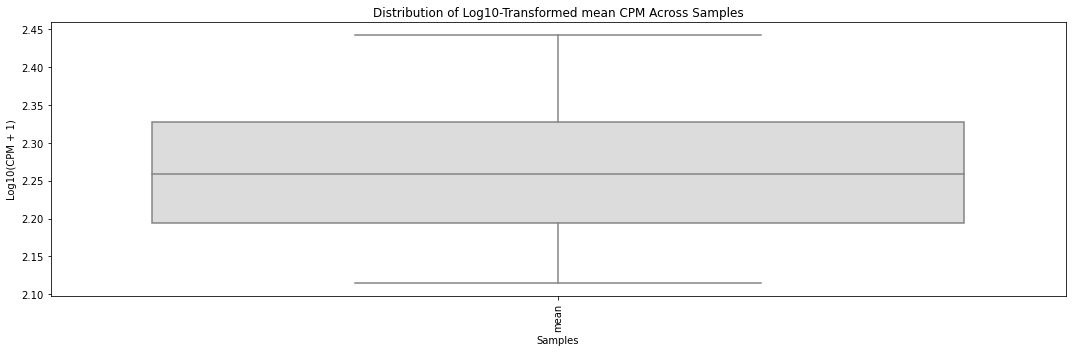

In [41]:
# Boxplot of CPM-normalized counts
plt.figure(figsize=(15, 5))
sns.boxplot(data=np.log10(raw_summary.T[['mean']] + 1), palette="coolwarm")
plt.title("Distribution of Log10-Transformed mean CPM Across Samples")
plt.xlabel("Samples")
plt.ylabel("Log10(CPM + 1)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


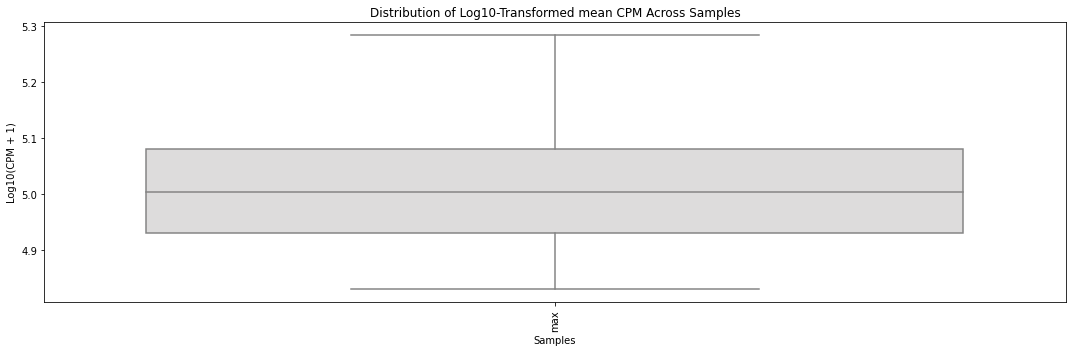

In [42]:
# Boxplot of CPM-normalized max counts
plt.figure(figsize=(15, 5))
sns.boxplot(data=np.log10(raw_summary.T[['max']] + 1), palette="coolwarm")
plt.title("Distribution of Log10-Transformed mean CPM Across Samples")
plt.xlabel("Samples")
plt.ylabel("Log10(CPM + 1)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# Boxplot of CPM-normalized max counts
plt.figure(figsize=(15, 5))
sns.boxplot(data=np.log10(raw_summary.T[['max']] + 1), palette="coolwarm")
plt.title("Distribution of Log10-Transformed mean CPM Across Samples")
plt.xlabel("Samples")
plt.ylabel("Log10(CPM + 1)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [38]:
raw_summary.T

,count,mean,std,min,25%,50%,75%,max
SRX9845534,32707.0,165.440053,1075.332847,0.0,2.0000,23.895,103.6600,91474.000
SRX9845541,32707.0,171.200147,957.385064,0.0,2.0000,25.000,110.7920,85682.000
SRX9845526,32707.0,192.577787,1048.747322,0.0,4.0000,33.037,131.2325,87475.000
SRX9845530,32707.0,211.851658,1345.628396,0.0,2.4890,28.248,126.0000,137044.000
SRX9845543,32707.0,136.141405,686.896627,0.0,2.0000,20.406,96.0000,69707.000
SRX9845527,32707.0,179.994930,1453.555755,0.0,2.0000,22.000,98.0000,147753.000
SRX9845506,32707.0,183.099091,1201.931238,0.0,2.0000,25.318,112.5605,112650.000
SRX9845518,32707.0,180.849091,974.852911,0.0,5.5815,32.227,125.0000,86589.000
SRX9845501,32707.0,159.277506,911.736745,0.0,2.4035,25.640,111.0000,86268.000
SRX9845536,32707.0,236.052346,1271.652215,0.0,5.0000,43.000,172.0000,100197.000


In [40]:
raw_summary.T[['mean']]

,mean
SRX9845534,165.440053
SRX9845541,171.200147
SRX9845526,192.577787
SRX9845530,211.851658
SRX9845543,136.141405
SRX9845527,179.994930
SRX9845506,183.099091
SRX9845518,180.849091
SRX9845501,159.277506
SRX9845536,236.052346


In [62]:
# Log-transform CPM data for Combat
log_cpm_data = np.log10(cpm_counts.iloc[:, 1:] + 1)
log_cpm_data.head()




,SRX9845534,SRX9845541,SRX9845526,SRX9845530,SRX9845543,SRX9845527,SRX9845506,SRX9845518,SRX9845501,SRX9845536,...,SRX9845505,SRX9845531,SRX9845510,SRX9845535,SRX9845513,SRX9845512,SRX9845525,SRX9845521,SRX9845500,SRX9845511
0,0.136598,0.076920,0.068847,0.000000,0.223687,0.178859,0.176366,0.266068,0.076261,0.280275,...,0.444962,0.240658,0.073524,0.429071,0.414348,0.166365,0.529522,0.157385,0.081188,0.338823
1,1.776473,0.416191,1.061460,0.361517,0.593234,0.807178,0.921544,0.224337,0.292209,0.000000,...,0.186324,1.336982,0.481325,0.748001,1.076306,0.457447,0.811491,0.157385,1.246752,0.634725
4,0.976184,1.615099,0.880931,0.736256,1.861310,1.461123,1.670401,1.630880,0.500412,1.236466,...,1.511933,1.548389,0.830142,1.288107,1.533238,1.193131,1.257932,1.245244,0.904844,0.868448
5,0.122906,0.437891,0.414129,0.452116,0.446635,0.273111,0.410352,0.481261,0.532831,0.668347,...,0.301321,0.332836,0.581791,0.495957,0.461756,0.486370,0.493621,0.445808,0.491850,0.397706
6,0.988917,1.067117,1.253353,1.269243,1.214500,1.173312,0.945427,1.195596,1.060592,1.361088,...,1.028970,1.300061,1.039837,1.292161,1.426175,1.084310,1.130240,1.032947,1.160286,0.942124


In [63]:
# Extract batch information
batch = metadata_subset.set_index('Sample').loc[log_cpm_data.columns, 'batch']
batch.head()


SRX9845534    2017
SRX9845541    2017
SRX9845526    2015
SRX9845530    2015
SRX9845543    2017
Name: batch, dtype: int64

In [72]:
# Initialize Combat with desired mode ('p' for parametric or 'np' for non-parametric)
combat = Combat(mode='p')

# Apply Combat's fit_transform method
combat_adjusted_data = combat.fit_transform(
    Y=log_cpm_data.T,  # Transpose: genes as rows, samples as columns
    b=batch            # Batch information
)


TypeError: '(slice(None, 2, None), slice(None, None, None))' is an invalid key

In [73]:
print("Shape of log_cpm_data.T:", log_cpm_data.T.shape)
print("Length of batch:", len(batch))
print("Batch index:", batch.index)
print("log_cpm_data.T columns:", log_cpm_data.T.columns)


Shape of log_cpm_data.T: (44, 32707)
Length of batch: 44
Batch index: Index(['SRX9845534', 'SRX9845541', 'SRX9845526', 'SRX9845530', 'SRX9845543',
       'SRX9845527', 'SRX9845506', 'SRX9845518', 'SRX9845501', 'SRX9845536',
       'SRX9845529', 'SRX9845524', 'SRX9845507', 'SRX9845540', 'SRX9845517',
       'SRX9845532', 'SRX9845503', 'SRX9845508', 'SRX9845537', 'SRX9845520',
       'SRX9845523', 'SRX9845528', 'SRX9845516', 'SRX9845514', 'SRX9845522',
       'SRX9845502', 'SRX9845509', 'SRX9845539', 'SRX9845542', 'SRX9845504',
       'SRX9845538', 'SRX9845515', 'SRX9845519', 'SRX9845533', 'SRX9845505',
       'SRX9845531', 'SRX9845510', 'SRX9845535', 'SRX9845513', 'SRX9845512',
       'SRX9845525', 'SRX9845521', 'SRX9845500', 'SRX9845511'],
      dtype='object')
log_cpm_data.T columns: Int64Index([    0,     1,     4,     5,     6,     7,     9,    10,    11,
               12,
            ...
            38253, 38254, 38256, 38257, 38258, 38259, 38260, 38261, 38262,
            38263],

In [74]:
# Ensure `log_cpm_data.T` uses sample IDs as indices
log_cpm_data.T.index = batch.index  # Align sample IDs

# Confirm alignment
assert all(log_cpm_data.T.index == batch.index), "Indices of log_cpm_data and batch do not match!"


In [76]:
# Ensure `log_cpm_data.T` and `batch` are NumPy arrays
log_cpm_data_array = log_cpm_data.T.values
batch_array = batch.values

# Apply Combat with parametric mode
combat = Combat(mode='p')
combat_adjusted_data = combat.fit_transform(
    Y=log_cpm_data_array,  # Use NumPy array
    b=batch_array          # Use NumPy array
)

# Convert adjusted data back to a DataFrame
combat_adjusted_cpm = pd.DataFrame(
    combat_adjusted_data.T,  # Transpose back to original format
    index=cpm_counts['gene_id'], 
    columns=cpm_counts.columns[1:]
)

/home/shellytrigg/bin/anaconda3/lib/python3.8/site-packages/pycombat/pycombat.py:79: RuntimeWarning: divide by zero encountered in true_divide
  (abs(del_sq_post - del_sq_prior) / del_sq_prior).max())


In [77]:
combat_adjusted_cpm.head()

,SRX9845534,SRX9845541,SRX9845526,SRX9845530,SRX9845543,SRX9845527,SRX9845506,SRX9845518,SRX9845501,SRX9845536,...,SRX9845505,SRX9845531,SRX9845510,SRX9845535,SRX9845513,SRX9845512,SRX9845525,SRX9845521,SRX9845500,SRX9845511
gene_id,,,,,,,,,,,,,,,,,,,,,
LOC111099029,0.167813,0.101085,0.057031,-0.005956,0.265190,0.157678,0.212279,0.237464,0.100347,0.250462,...,0.512605,0.214217,0.097288,0.386592,0.373123,0.201097,0.478493,0.138032,0.105857,0.393927
LOC111099030,1.641251,0.391587,1.120833,0.402864,0.554232,0.860002,0.855845,0.262151,0.277687,0.032037,...,0.180413,1.403450,0.451424,0.799301,1.136061,0.429488,0.864426,0.193475,1.154606,0.592350
LOC111099033,0.981560,1.634338,0.887260,0.748817,1.885891,1.442460,1.690840,1.604905,0.495465,1.227480,...,1.528934,1.525967,0.832350,1.276897,1.511469,1.203214,1.248022,1.235880,0.908672,0.871487
LOC111099034,0.102217,0.417978,0.430214,0.466941,0.426744,0.293874,0.390371,0.495119,0.513152,0.675999,...,0.281071,0.351617,0.562233,0.509328,0.476261,0.466577,0.507069,0.460842,0.472070,0.377694
LOC111099035,0.999655,1.086512,1.227465,1.242055,1.250210,1.153973,0.951351,1.174433,1.079264,1.326385,...,1.044142,1.270351,1.056212,1.263098,1.386146,1.105608,1.114425,1.025093,1.189994,0.947682


In [78]:
# Remove zero-variance genes
non_zero_variance_genes = log_cpm_data.var(axis=0) > 0
log_cpm_data_filtered = log_cpm_data.loc[:, non_zero_variance_genes]

In [79]:
combat_adjusted_data = combat.fit_transform(
    Y=log_cpm_data_filtered.T.values,
    b=batch.values
)

/home/shellytrigg/bin/anaconda3/lib/python3.8/site-packages/pycombat/pycombat.py:79: RuntimeWarning: divide by zero encountered in true_divide
  (abs(del_sq_post - del_sq_prior) / del_sq_prior).max())


In [84]:
# Check for NaN or infinite values in the adjusted data
print(np.isfinite(combat_adjusted_data).all())  # Should return True

True


In [81]:
# Remove low-variance genes
low_variance_threshold = 1e-6  # Define a small threshold
non_low_variance_genes = log_cpm_data.var(axis=0) > low_variance_threshold
log_cpm_data_filtered = log_cpm_data.loc[:, non_low_variance_genes]


In [82]:
# Clip values to avoid numerical instability
log_cpm_data_clipped = log_cpm_data_filtered.clip(lower=1e-6)


In [83]:
combat_adjusted_data = combat.fit_transform(
    Y=log_cpm_data_clipped.T.values,
    b=batch.values
)

/home/shellytrigg/bin/anaconda3/lib/python3.8/site-packages/pycombat/pycombat.py:79: RuntimeWarning: divide by zero encountered in true_divide
  (abs(del_sq_post - del_sq_prior) / del_sq_prior).max())


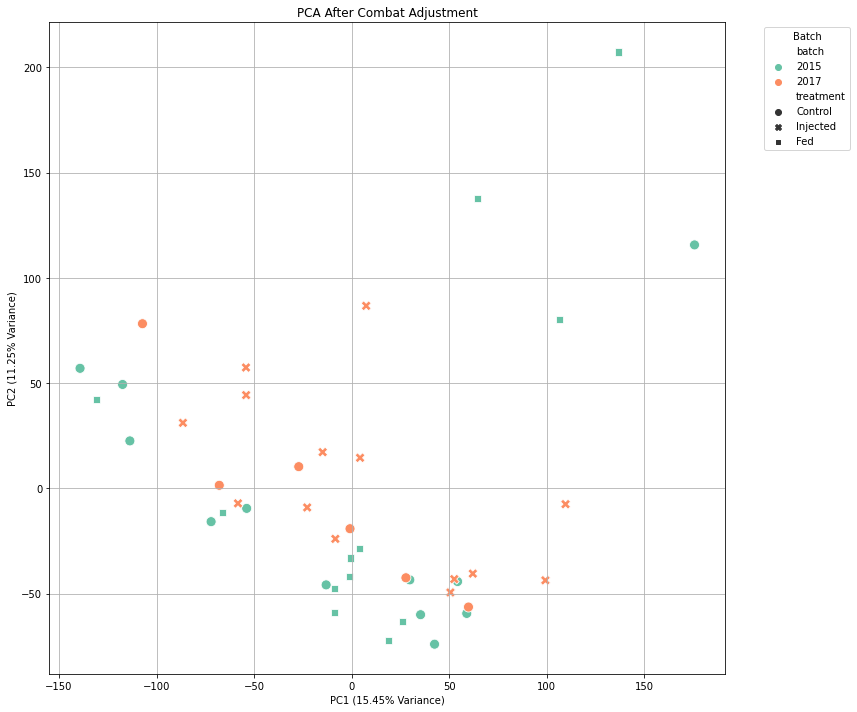

In [85]:
# Perform PCA on Combat-adjusted data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combat_adjusted_cpm.T)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Create a PCA DataFrame
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])
pca_df['Sample'] = combat_adjusted_cpm.columns
pca_df = pd.merge(pca_df, metadata_subset, left_on='Sample', right_on='Sample')

# Plot PCA after Combat adjustment
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='batch', style='treatment',
    s=100, palette='Set2'
)
plt.title('PCA After Combat Adjustment')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Batch', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

If the PCA plot looks the same before and after batch effect correction, this could indicate one of the following:

Possible Explanations

Insufficient Batch Adjustment: Combat may not have fully corrected the batch effects.
This can happen if batch is highly confounded with other factors (e.g., treatment or time point).

Low Impact of Batch: Batch effects might not have been a major source of variance in the data to begin with.PCA often highlights dominant sources of variation, which may be unrelated to batch.

Residual Batch Effects in High Variance Genes:The Combat adjustment could have reduced batch effects in most genes, but residual effects might remain in genes with the highest variance.

Biological Signals are Confounded with Batch: If batch and biological variables (e.g., treatment or time point) are correlated, Combat may struggle to disentangle them.
